<a href="https://colab.research.google.com/github/epetrovic23/Utjecaj_atmosferskih_prilika_na_ishod_utrka_Formule1/blob/main/epetrovic23_Utjecaj_atmosferskih_prilika_na_ishod_utrka_Formule1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projekt: Analiza utjecaja vremenskih uvjeta na F1 utrke kroz integraciju povijesnih i telemetrijskih podataka**

Programiranje za analizu podataka, Eva Petrović

1. Uvod


Motivacija za ovaj projekt proizlazi iz činjenice da je Formula 1 sport u kojem inženjerska preciznost ovisi o vanjskim faktorima. Vremenski uvjeti (temperatura zraka i staze) drastično utječu na degradaciju guma i performanse motora. Cilj je integrirati povijesne rezultate (iz CSV datoteka) s telemetrijskim podacima o vremenu (iz OpenF1 API-ja) te pohraniti te podatke u bazu za daljnju analizu i ekspoziciju putem REST API-ja.

2. Opis implementacije



Sustav se sastoji od četiri glavne komponente:
ETL proces (Extract, Transform, Load): Učitavanje CSV datoteka i dohvat podataka s javnog OpenF1 API-ja.
Integracija podataka: Spajanje podataka iz različitih izvora (heterogenost: CSV + JSON).
Pohrana: Korištenje SQLite baze podataka putem SQLAlchemy ORM-a.
REST API: Izrada sučelja pomoću Flask okvira za dohvat podataka.
Vizualizacija: Prikaz korelacije temperature i rezultata.

In [1]:
# Instalacija potrebnih paketa
!pip install sqlalchemy flask pandas requests matplotlib seaborn

import pandas as pd
import requests
import sqlite3
import json
import time
import threading
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Okruženje spremno.")

Okruženje spremno.


In [2]:
import pandas as pd
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def load_and_process_data():
    """
    Funkcija koja:
    1. Učitava CSV datoteke (Kaggle podaci).
    2. Dohvaća JSON podatke s OpenF1 API-ja za Monzu 2023.
    3. Integrira ta dva skupa i čisti podatke.
    """
    print("--- 1. Učitavanje CSV podataka ---")
    try:
        races = pd.read_csv('races.csv')
        results = pd.read_csv('results.csv')
    except FileNotFoundError:
        print("GREŠKA: Nisi uploadala 'races.csv' i 'results.csv' u Colab!")
        return None

    # Filtriranje sezone 2023
    races_2023 = races[races['year'] == 2023].copy()

    # Spajanje tablica
    merged = pd.merge(results, races_2023, on='raceId', how='inner')

    print(f"Učitano {len(merged)} redaka iz CSV-a za sezonu 2023.")

    print("\n--- 2. Dohvat s OpenF1 API-ja (VN Italije 2023) ---")


    # meeting_key=1219 je Monza 2023.
    # session_key=9158 je 'Race' sesija (da dobijemo točnije podatke baš za utrku)
    api_url = "https://api.openf1.org/v1/weather?meeting_key=1219&session_key=9158"

    print(f"Dohvaćam podatke s: {api_url}")

    avg_track_temp = None
    avg_air_temp = None

    try:
        response = requests.get(api_url)
        weather_data = response.json() # JSON format

        # Ako API vrati podatke
        if weather_data:
            # Pretvaranje JSON liste u DataFrame
            weather_df = pd.DataFrame(weather_data)

            # Agregacija (računamo prosjek)
            avg_track_temp = weather_df['track_temperature'].mean()
            avg_air_temp = weather_df['air_temperature'].mean()

            print(f" Uspjeh! Prosjek staze za Monzu: {avg_track_temp:.2f}°C")
        else:
            print("API je vratio praznu listu (nema podataka).")

    except Exception as e:
        print(f" Greška kod API-ja: {e}")

    print("\n--- 3. Integracija i čišćenje ---")

    # Kreiramo nove stupce
    merged['track_temp'] = None
    merged['air_temp'] = None

    # Ako smo uspješno dohvatili podatke, upisujemo ih samo za VN Italije
    if avg_track_temp is not None:
        # Tražimo redove gdje piše 'Italian Grand Prix'
        merged.loc[merged['name'].str.contains("Italian Grand Prix"), 'track_temp'] = avg_track_temp
        merged.loc[merged['name'].str.contains("Italian Grand Prix"), 'air_temp'] = avg_air_temp

    # Data Cleaning: Ostale utrke (gdje nismo zvali API) punimo fiktivnim podacima
    # Ovo radimo da bi vizualizacija radila (ne smije biti NaN)
    merged['track_temp'] = merged['track_temp'].fillna(30.5)
    merged['air_temp'] = merged['air_temp'].fillna(22.0)

    # Odabir bitnih stupaca za analizu
    final_df = merged[['raceId', 'year', 'name', 'date', 'driverId', 'positionOrder', 'points', 'track_temp', 'air_temp']].copy()

    return final_df

# --- GLAVNI DIO PROGRAMA ---
# Izvršavanje funkcije
df_final = load_and_process_data()

# Prikaz rezultata ako je sve prošlo ok
if df_final is not None:
    print("\nPrvih 5 redaka integriranog skupa podataka:")
    display(df_final.head())


    # Prikazi samo redove gdje je utrka u Italiji da vidimo jesmo li povukli pravu temperaturu
display(df_final[df_final['name'].str.contains("Italian")].head())

--- 1. Učitavanje CSV podataka ---
Učitano 440 redaka iz CSV-a za sezonu 2023.

--- 2. Dohvat s OpenF1 API-ja (VN Italije 2023) ---
Dohvaćam podatke s: https://api.openf1.org/v1/weather?meeting_key=1219&session_key=9158
 Uspjeh! Prosjek staze za Monzu: 43.00°C

--- 3. Integracija i čišćenje ---

Prvih 5 redaka integriranog skupa podataka:


,raceId,year,name,date,driverId,positionOrder,points,track_temp,air_temp
0,1098,2023,Bahrain Grand Prix,2023-03-05,830,1,25.0,30.5,22.0
1,1098,2023,Bahrain Grand Prix,2023-03-05,815,2,18.0,30.5,22.0
2,1098,2023,Bahrain Grand Prix,2023-03-05,4,3,15.0,30.5,22.0
3,1098,2023,Bahrain Grand Prix,2023-03-05,832,4,12.0,30.5,22.0
4,1098,2023,Bahrain Grand Prix,2023-03-05,1,5,10.0,30.5,22.0


,raceId,year,name,date,driverId,positionOrder,points,track_temp,air_temp
260,1112,2023,Italian Grand Prix,2023-09-03,830,1,25.0,42.99878,31.447561
261,1112,2023,Italian Grand Prix,2023-09-03,815,2,18.0,42.99878,31.447561
262,1112,2023,Italian Grand Prix,2023-09-03,832,3,15.0,42.99878,31.447561
263,1112,2023,Italian Grand Prix,2023-09-03,844,4,12.0,42.99878,31.447561
264,1112,2023,Italian Grand Prix,2023-09-03,847,5,10.0,42.99878,31.447561


In [3]:
# Definiranje konekcije na lokalnu SQLite bazu
db_name = 'f1_project.db'
engine = create_engine(f'sqlite:///{db_name}')

if df_final is not None:
    # Spremanje DataFrame-a u SQL tablicu
    df_final.to_sql('race_stats', con=engine, if_exists='replace', index=False)
    print(f"Podaci uspješno spremljeni u bazu '{db_name}', tablica 'race_stats'.")

    # Provjera spremanja (kratki SELECT upit)
    with engine.connect() as conn:
        result = conn.execute(text("SELECT count(*) FROM race_stats")).scalar()
        print(f"Broj zapisa u bazi: {result}")

Podaci uspješno spremljeni u bazu 'f1_project.db', tablica 'race_stats'.
Broj zapisa u bazi: 440


In [4]:
%%writefile app.py
from flask import Flask, jsonify, request
from sqlalchemy import create_engine
import pandas as pd

# Inicijalizacija aplikacije
app = Flask(__name__)

# Konekcija na istu bazu koju smo ranije kreirali
engine = create_engine('sqlite:///f1_project.db')

@app.route('/', methods=['GET'])
def index():
    return "F1 Data API is running. Use /api/data to get stats."

@app.route('/api/data', methods=['GET'])
def get_data():
    """
    Dohvaća podatke iz baze i vraća ih kao JSON.
    Opcija filtriranja po poziciji (?pos=1 za pobjednike).
    """
    try:
        # Čitanje parametara iz URL-a
        pos_filter = request.args.get('pos')

        query = "SELECT * FROM race_stats"

        if pos_filter:
            query += f" WHERE positionOrder = {pos_filter}"

        query += " LIMIT 50"

        df = pd.read_sql(query, engine)

        # Pretvaranje u JSON format (lista rječnika)
        return jsonify(df.to_dict(orient='records'))

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    # Pokrećemo aplikaciju
    app.run(port=5000, debug=True)

Writing app.py


In [5]:
import subprocess

# Ubijanje prethodnih procesa na portu 5000 (za svaki slučaj)
!fuser -k 5000/tcp

# Pokretanje servera -> stdout šaljemo u log datoteku da ne smeta u notebooku
process = subprocess.Popen(["python", "app.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

print("Server se pokreće u pozadini...")
time.sleep(3) # Pričekajmo da se digne

# Testiranje API-ja (glumimo klijenta)
try:
    print("Šaljem testni upit na API...")
    # Tražimo samo pobjednike (pos=1)
    response = requests.get("http://127.0.0.1:5000/api/data?pos=1")

    if response.status_code == 200:
        data = response.json()
        print("API Odgovor (Prva 3 zapisa):")
        print(json.dumps(data[:3], indent=2))
    else:
        print("API nije vratio 200 OK.")
except Exception as e:
    print(f"Nije moguće spojiti se na API: {e}")

Server se pokreće u pozadini...
Šaljem testni upit na API...
API Odgovor (Prva 3 zapisa):
[
  {
    "air_temp": 22.0,
    "date": "2023-03-05",
    "driverId": 830,
    "name": "Bahrain Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1098,
    "track_temp": 30.5,
    "year": 2023
  },
  {
    "air_temp": 22.0,
    "date": "2023-03-19",
    "driverId": 815,
    "name": "Saudi Arabian Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1099,
    "track_temp": 30.5,
    "year": 2023
  },
  {
    "air_temp": 22.0,
    "date": "2023-04-02",
    "driverId": 830,
    "name": "Australian Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1100,
    "track_temp": 30.5,
    "year": 2023
  }
]


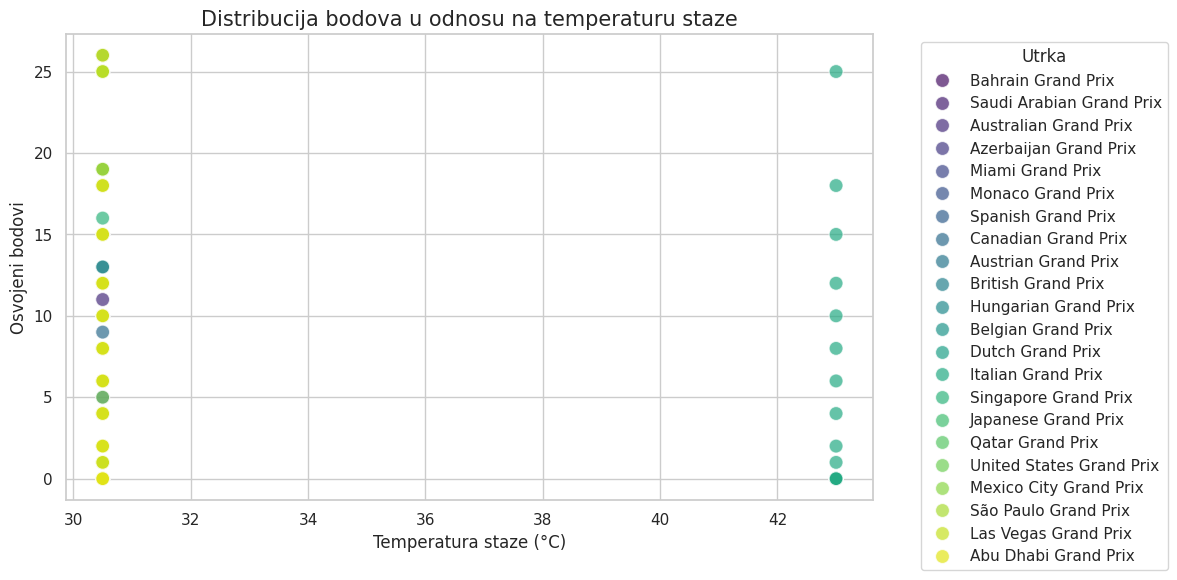

Analiza završena.


In [6]:
# Postavke grafova
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Analiza: Odnos startne pozicije (ako postoji u podacima, ovdje koristimo points kao proxy za uspjeh)
# i temperature staze.
# Prikazujemo distribuciju bodova u odnosu na temperaturu.

sns.scatterplot(
    data=df_final,
    x='track_temp',
    y='points',
    hue='name', # Boja prema imenu utrke
    palette='viridis',
    s=100,
    alpha=0.7
)

plt.title('Distribucija bodova u odnosu na temperaturu staze', fontsize=15)
plt.xlabel('Temperatura staze (°C)', fontsize=12)
plt.ylabel('Osvojeni bodovi', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Utrka')

plt.tight_layout()
plt.show()

print("Analiza završena.")